# **Building a GAN trained on MNIST dataset to generate new handwritten digits**

### **Description** 

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images. The idea behind GANs involves two networks, a generator 𝐺 and a discriminator 𝐷, that compete against each other. The generator makes "fake" data to pass to the discriminator. The discriminator is a classifier that is trained to figure out which data is real and which is fake. The latent sample is a random vector the generator uses to construct it’s fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator. The general structure of a GAN is shown in the diagram above, using MNIST images as data. 

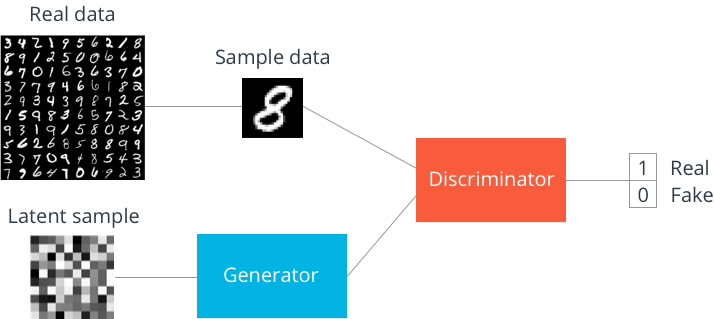


Source of the image: https://towardsdatascience.com/gan-introduction-and-implementation-part1-implement-a-simple-gan-in-tf-for-mnist-handwritten-de00a759ae5c

In [1]:
# Import necessary libraries

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from keras.layers import Input, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import UpSampling2D, Flatten, Activation
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as k

from keras.datasets import mnist

In [2]:
# Set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

### **Load the train and test data**


In [3]:
(X_train, y_train), (X_test, y_test) =  mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### **Visualize the data**


In [4]:
print('Size of the train_set: ', X_train.shape)
print('Size of the test_set: ', X_train.shape)
print('Shape of each image: ', X_train[0].shape)
print('Total number of classes: ', len(np.unique(y_train)))
print('Unique class labels: ', np.unique(y_train))

Size of the train_set:  (60000, 28, 28)
Size of the test_set:  (60000, 28, 28)
Shape of each image:  (28, 28)
Total number of classes:  10
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


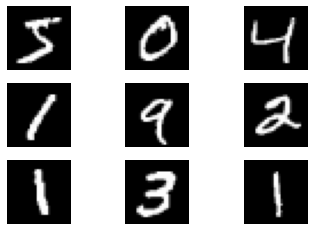

In [5]:
# Plot of 9 random images
for i in range(0, 9):
    plt.subplot(331+i)                    # plot of 3 rows and 3 columns
    plt.axis('off')                       # turn off axis
    plt.imshow(X_train[i], cmap='gray')   # gray scale

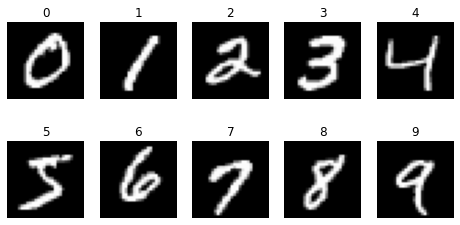

In [6]:
# Plot image from each class
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(str(i))   # label 
    plt.axis('off')     # turn off axis
    plt.imshow(X_train[np.where(y_train==i)][0], cmap='gray') # gray scale
plt.show()

In [7]:
print('Maximum pixel value in the training_set: ', np.max(X_train))
print('Minimum pixel value in the training_set: ', np.min(X_train))

Maximum pixel value in the training_set:  255
Minimum pixel value in the training_set:  0


### **Scaling and centering**

In [8]:
# Convert integer values to float types 
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Scaling and centering
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5)/ 127.5

print('Maximum pixel value in the training_set after Centering and Scaling: ', np.max(X_train))
print('Minimum pixel value in the training_set after Centering and Scaling: ', np.min(X_train))

Maximum pixel value in the training_set after Centering and Scaling:  1.0
Minimum pixel value in the training_set after Centering and Scaling:  -1.0


### **Rescaling the pixel values**

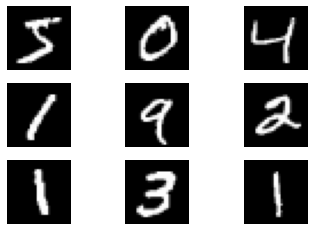

In [9]:
# Rescale the pixel values (0 and 255)
def upscale(image):
    return (image*127.5 + 127.5).astype(np.uint8)

for i in range(0, 9):
    plt.subplot(331+i)  # plot of 3 rows and 3 columns
    plt.axis('off')     # turn off axis
    plt.imshow(upscale(X_train[i]), cmap='gray') # gray scale

### **Creating Noised Images**

In [10]:
def noising(image):
    array = np.array(image)
    i = random.choice(range(8,12)) # x coordinate for the top left corner of the mask
    j = random.choice(range(8,12)) # y coordinate for the top left corner of the mask
    array[i:i+8, j:j+8]=-1.0 # setting the pixels in the masked region to -1
    return array

noised_train_data = np.array([*map(noising, X_train)])
noised_test_data = np.array([*map(noising, X_test)])
print('Noised train data Dimension : ', noised_train_data.shape)
print('Noised test Dimension : ', noised_train_data.shape)

Noised train data Dimension :  (60000, 28, 28)
Noised test Dimension :  (60000, 28, 28)


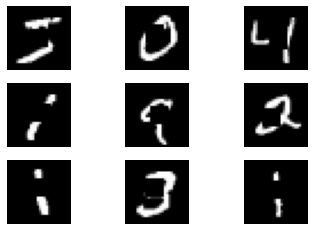

In [11]:
# Plot of 9 scaled noised images after upscaling
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(noised_train_data[i]), cmap='gray') # gray scale

### **Preprocess input data**

In [12]:
# Reshape the training data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('Size of the original training set: ', X_train.shape)

# Reshape the nosied training data
noised_train_data = noised_train_data.reshape(noised_train_data.shape[0],
                                              noised_train_data.shape[1],
                                              noised_train_data.shape[2], 1)
print('Size of the noised training set: ', noised_train_data.shape)

# Reshape the testing data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Size of the original test set: ', X_test.shape)

# Reshape the noised testing data
noised_test_data = noised_test_data.reshape(noised_test_data.shape[0],
                                            noised_test_data.shape[1],
                                            noised_test_data.shape[2], 1)
print('Size of the noised test set: ', noised_test_data.shape)

Size of the original training set:  (60000, 28, 28, 1)
Size of the noised training set:  (60000, 28, 28, 1)
Size of the original test set:  (10000, 28, 28, 1)
Size of the noised test set:  (10000, 28, 28, 1)


In [13]:
from keras import backend as k
k.clear_session()

### **Model Architecture**

In [14]:
# Input image shape
input_shape = (28,28,1)

def train_mnist(input_shape, X_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=2, padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'adam', metrics = ['accuracy'])
    model.fit(X_train, y_train, batch_size = 128,  
              epochs = 3, validation_split=0.2, verbose = 1 )
    return model

mnist_model = train_mnist(input_shape, X_train, y_train)

Epoch 1/3
375/375 [==============================] - 91s 241ms/step - loss: 0.2276 - accuracy: 0.9302 - val_loss: 0.0632 - val_accuracy: 0.9814
Epoch 2/3
375/375 [==============================] - 89s 238ms/step - loss: 0.0676 - accuracy: 0.9785 - val_loss: 0.0434 - val_accuracy: 0.9872
Epoch 3/3
375/375 [==============================] - 89s 238ms/step - loss: 0.0478 - accuracy: 0.9849 - val_loss: 0.0404 - val_accuracy: 0.9880


### **Prediction on masked images**

In [15]:
pred_labels = mnist_model.predict_classes(noised_test_data)
print('The model model accuracy on the masked images is:',np.mean(pred_labels==y_test)*100)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The model model accuracy on the masked images is: 77.03


In [16]:
# Smoothing value
smooth_real = 0.9

# Number of epochs
epochs = 5

# Batchsize
batch_size = 128

# Optimizer for the generator
optimizer_g = Adam(lr=0.0002, beta_1=0.5)

# Optimizer for the discriminator
optimizer_d = Adam(lr=0.0004, beta_1=0.5)

# Shape of the input image
input_shape = (28,28,1)

### **Generator**

In [17]:
def img_generator(input_shape):
    generator = Sequential()
    generator.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape)) # 32 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu'))
    generator.add(AveragePooling2D(pool_size=(2, 2)))
    
    generator.add(Conv2D(64, (3, 3), padding='same')) # 64 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu'))
    generator.add(AveragePooling2D(pool_size=(2, 2)))
    
    generator.add(Conv2D(128, (3, 3), padding='same')) # 128 filters
    generator.add(BatchNormalization())
    generator.add(Activation('relu')) 
    
    generator.add(Conv2D(128, (3, 3), padding='same')) # 128 filters
    generator.add(Activation('relu'))
    generator.add(UpSampling2D((2,2)))
    
    generator.add(Conv2D(64, (3, 3), padding='same')) # 64 filters
    generator.add(Activation('relu'))
    generator.add(UpSampling2D((2,2)))
    
    generator.add(Conv2D(1, (3, 3), activation='tanh', padding='same')) # 1 filter
    return generator

In [18]:
# Print generator summary
img_generator(input_shape).summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 64)       

### **Discriminator**

In [19]:
def img_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3, 3), strides=2, padding='same', input_shape=input_shape, activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), padding='same', activation = 'linear'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator


In [20]:
# Print discriminator summary
img_discriminator(input_shape).summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)        

### **DCGAN**

In [21]:
def dcgan(discriminator, generator, input_shape):
    # Don't train the discriminator when compiling GAN
    discriminator.trainable = False

    # Accepts the noised input
    gan_input = Input(shape=input_shape)
    
    # Generates image by passing the above received input to the generator
    gen_img = generator(gan_input)
    
    # Feeds the generated image to the discriminator
    gan_output = discriminator(gen_img)
    
    # Compile everything as a model with binary crossentropy loss
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

In [22]:
def generated_images_plot(original, noised_data, generator):
    
    print('NOISED')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(noised_data[i])), cmap='gray') # upscale for plotting
    plt.show()
    
    print('GENERATED')
    for i in range(9):
        pred = generator.predict(noised_data[i:i+1], verbose=0)
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(pred[0])), cmap='gray') # upscale to avoid plotting errors
    plt.show()
    
    print('ORIGINAL')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(upscale(np.squeeze(original[i])), cmap='gray') # upscale for plotting
    plt.show()

In [23]:
def plot_generated_images_combined(original, noised_data, generator):
    rows, cols = 4, 12
    num = rows * cols
    image_size = 28

    generated_images = generator.predict(noised_data[0:num])
    
    imgs = np.concatenate([original[0:num], noised_data[0:num], generated_images])
    imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
    imgs = np.vstack(np.split(imgs, rows, axis=1))
    imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    imgs = upscale(imgs)
    plt.figure(figsize=(8,16))
    plt.axis('off')
    plt.title('Original Images: top rows, '
              'Corrupted Input: middle rows, '
              'Generated Images: bottom rows')
    plt.imshow(imgs, cmap='gray')
    plt.show()

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1
Iteration - %d 1
NOISED


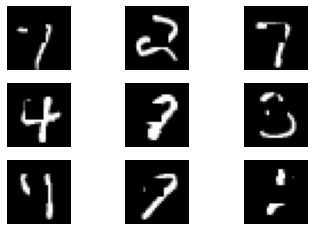

GENERATED


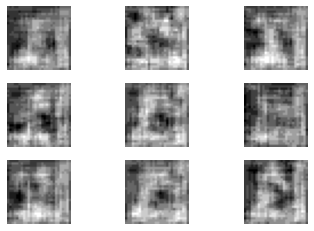

ORIGINAL


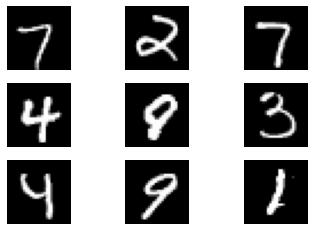

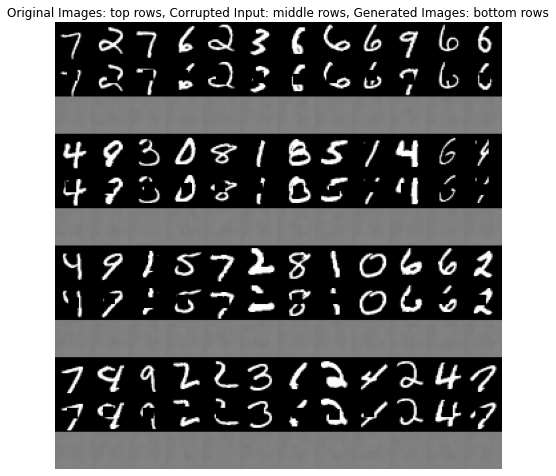

100%|██████████| 468/468 [16:16<00:00,  2.09s/it]


Discriminator Loss:  0.5655694007873535 , Adversarial Loss:  1.8193269968032837
NOISED


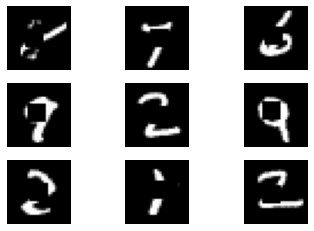

GENERATED


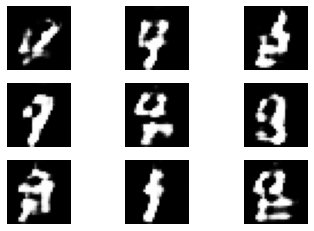

ORIGINAL


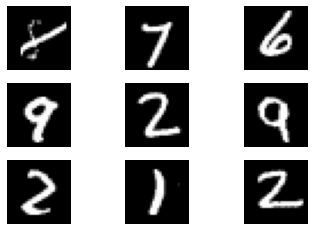

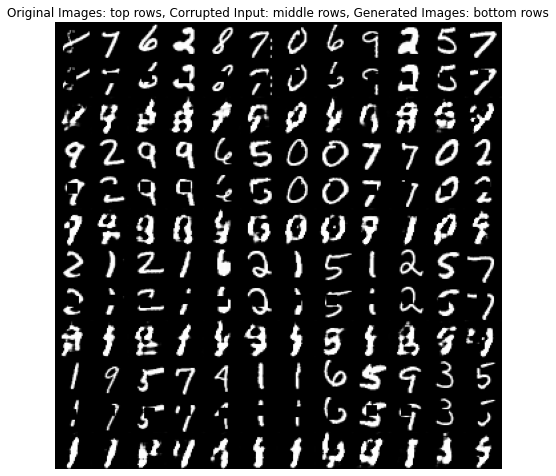

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2


100%|██████████| 468/468 [16:11<00:00,  2.08s/it]


Discriminator Loss:  0.6152967810630798 , Adversarial Loss:  0.948089599609375
NOISED


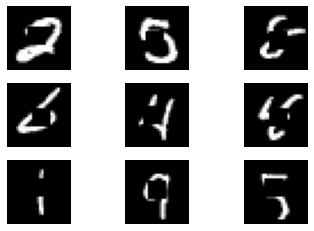

GENERATED


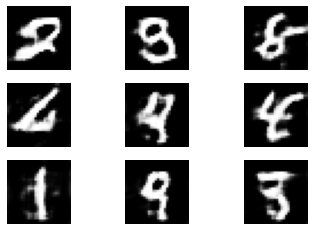

ORIGINAL


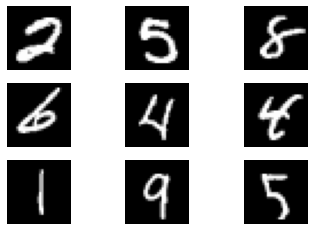

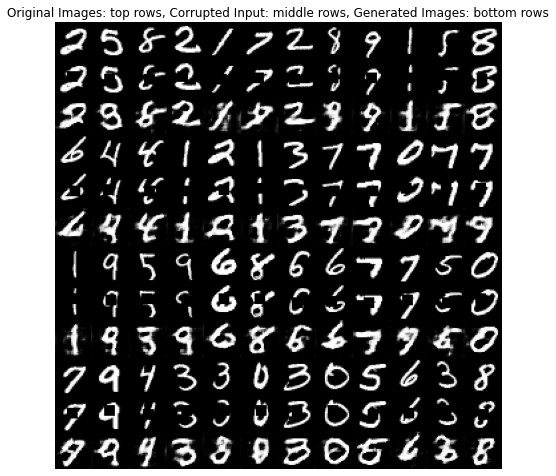

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3


100%|██████████| 468/468 [16:18<00:00,  2.09s/it]


Discriminator Loss:  0.6499617695808411 , Adversarial Loss:  0.8991855978965759
NOISED


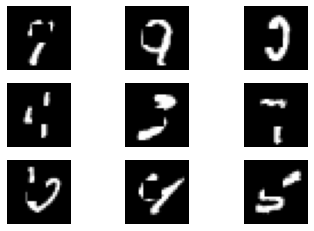

GENERATED


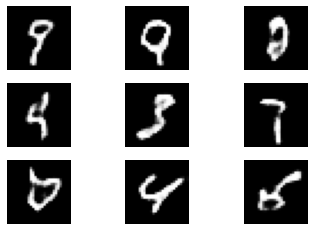

ORIGINAL


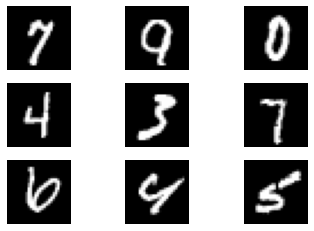

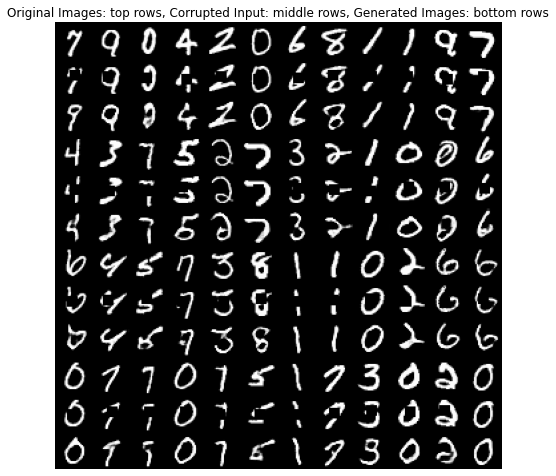

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4


100%|██████████| 468/468 [16:06<00:00,  2.07s/it]


Discriminator Loss:  0.6388808488845825 , Adversarial Loss:  0.9114909172058105
NOISED


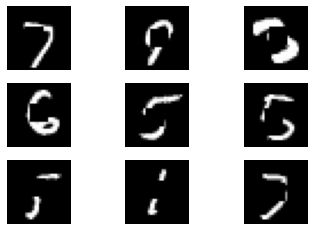

GENERATED


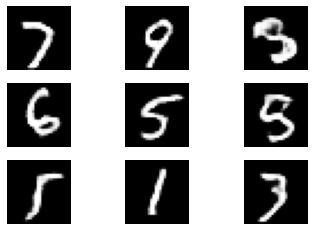

ORIGINAL


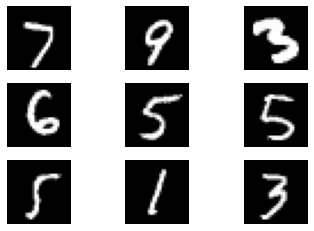

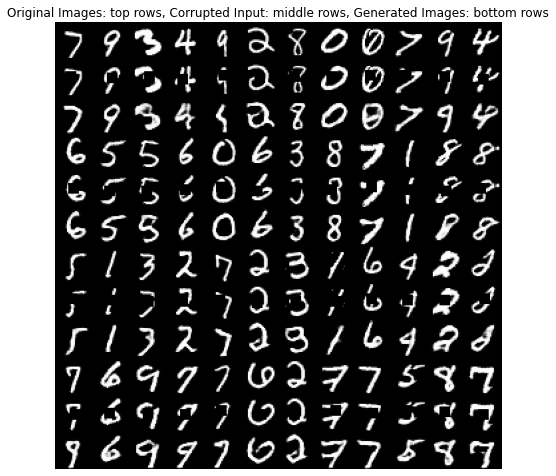

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5


100%|██████████| 468/468 [16:06<00:00,  2.07s/it]


Discriminator Loss:  0.5901482105255127 , Adversarial Loss:  1.0051662921905518
NOISED


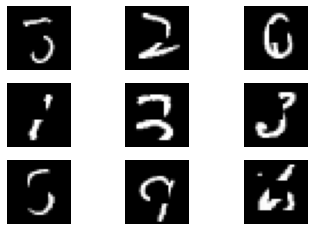

GENERATED


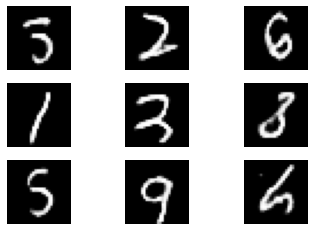

ORIGINAL


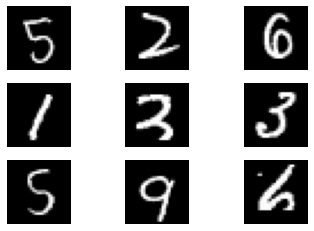

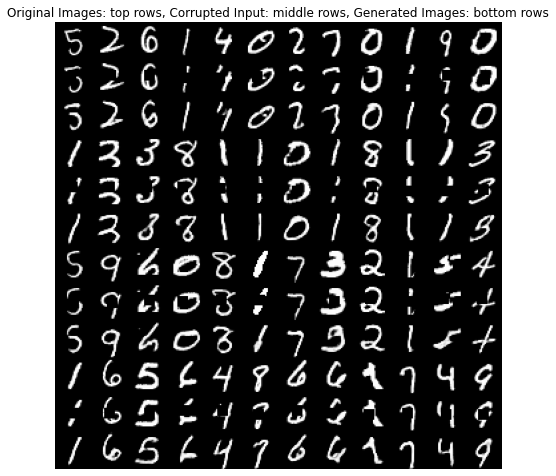

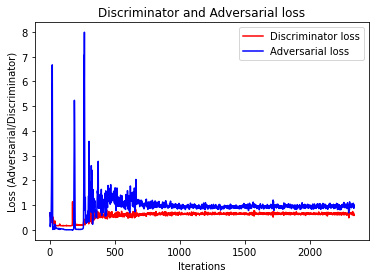

In [24]:
def train(X_train, noised_train_data,
          input_shape, smooth_real,
          epochs, batch_size,
          optimizer_g, optimizer_d):

    # Define two empty lists to store the discriminator
    # and the generator losses
    discriminator_losses = []
    generator_losses = []
    
    # Number of iteration possible with batches of size 128
    iterations = X_train.shape[0] // batch_size

    # Load the generator and the discriminator
    generator = img_generator(input_shape)
    discriminator = img_discriminator(input_shape)
    
    # Compile the discriminator with binary_crossentropy loss
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer_d)
    
    # Feed the generator and the discriminator to the function dcgan
    # to form the DCGAN architecture
    gan = dcgan(discriminator, generator, input_shape)
    
    # Compile the DCGAN with binary_crossentropy loss
    gan.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    for i in range(epochs):
        print ('Epoch %d' % (i+1))
        # Use tqdm to get an estimate of time remaining
        for j in tqdm(range(1, iterations+1)):
            
            # batch of original images (batch = batchsize)
            original = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # batch of noised images (batch = batchsize)
            noise = noised_train_data[np.random.randint(0, noised_train_data.shape[0], size=batch_size)]

            # Generate fake images
            generated_images = generator.predict(noise)
            
            # Labels for generated data
            dis_lab = np.zeros(2*batch_size)
            
            # data for discriminator
            dis_train = np.concatenate([original, generated_images])
            
            # label smoothing for original images
            dis_lab[:batch_size] = smooth_real
            
            # Train discriminator on original iamges
            discriminator.trainable = True
            discriminator_loss = discriminator.train_on_batch(dis_train, dis_lab)
            
            # save the losses 
            discriminator_losses.append(discriminator_loss)

            # Train generator
            gen_lab = np.ones(batch_size)
            discriminator.trainable = False
            sample_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            original = X_train[sample_indices]
            noise = noised_train_data[sample_indices]
            
            generator_loss = gan.train_on_batch(noise, gen_lab)
            
            # save the losses
            generator_losses.append(generator_loss)
            
            if i == 0 and j == 1:
                print('Iteration - %d', j)
                generated_images_plot(original, noise, generator)
                plot_generated_images_combined(original, noise, generator)
        
        print("Discriminator Loss: ", discriminator_loss,\
              ", Adversarial Loss: ", generator_loss)
        
        # training plot 1
        generated_images_plot(original, noise, generator)
        # training plot 2
        plot_generated_images_combined(original, noise, generator)

    # plot the training losses
    plt.figure()
    plt.plot(range(len(discriminator_losses)), discriminator_losses,
             color='red', label='Discriminator loss')
    plt.plot(range(len(generator_losses)), generator_losses,
             color='blue', label='Adversarial loss')
    plt.title('Discriminator and Adversarial loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Adversarial/Discriminator)')
    plt.legend()
    plt.show()
    
    return generator

generator = train(X_train, noised_train_data,
                  input_shape, smooth_real,
                  epochs, batch_size,
                  optimizer_g, optimizer_d)


In [25]:
# Restore missing parts of the digit with the generator
gen_imgs_test = generator.predict(noised_test_data)

### **Prediction on the restored/generated digits**

In [26]:
gen_pred_lab = mnist_model.predict_classes(gen_imgs_test)
print('The model accuracy on the generated images is:',np.mean(gen_pred_lab==y_test)*100)

The model accuracy on the generated images is: 86.92999999999999


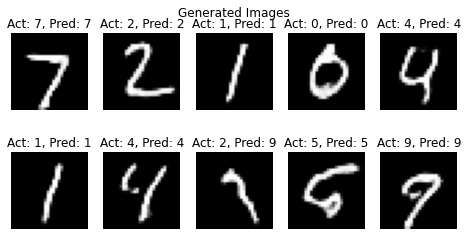

In [27]:
# Plot of 10 generated images and their predicted label
fig=plt.figure(figsize=(8, 4))
plt.title('Generated Images')
plt.axis('off') 
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title('Act: %d, Pred: %d'%(gen_pred_lab[i],y_test[i])) # label 
    plt.axis('off') # turn off axis
    plt.imshow(upscale(np.squeeze(gen_imgs_test[i])), cmap='gray') # gray scale
plt.show()